In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [2]:
vb = pd.read_csv("../data/vb_data_3_categZone.csv")
vbn = pd.read_csv("../data/vb_data_3_numZone.csv")
print(len(vb), 'lines loaded')

146050 lines loaded


In [3]:
X = vb.drop(['Season', 'GameID', 'PlayerTeam', 'PlayerName', 'RewardDistance', 'RewardValue'], axis=1)
Xn = vbn.drop(['Season', 'GameID', 'PlayerTeam', 'PlayerName', 'RewardDistance', 'RewardValue'], axis=1)
#zone_cols = [col for col in list(X.columns) if 'Start' in col or 'End' in col or 'Zone' in col]
#outcome_cols = [col for col in list(X.columns) if 'Outcome' in col]

#experiment without zones
#X = X.drop(outcome_cols, axis=1)

print(len(X.columns), 'columns in categorical dataframe')
print(len(Xn.columns), 'columns in numerical dataframe')

cols = [col for col in list(X.columns) if X[col].dtype == 'object']
X = pd.get_dummies(data=X, columns = cols)
y = vb.RewardValue

cols = [col for col in list(Xn.columns) if Xn[col].dtype == 'object']
Xn = pd.get_dummies(data=Xn, columns = cols)
yn = vbn.RewardValue

print(len(X.columns), 'columns in categorical dataframe after dummies')
print(len(Xn.columns), 'columns in numerical dataframe after dummies')

73 columns in categorical dataframe
93 columns in numerical dataframe
926 columns in categorical dataframe after dummies
204 columns in numerical dataframe after dummies


In [5]:
depth = []
for i in range(300,500,50):
    print('Checking max_features =', i)
    clf = RandomForestClassifier(n_estimators=100, max_features=i, max_depth=12)
    # Perform 5-fold cross validation
    scores = cross_val_score(estimator=clf, X=X, y=y, cv=5, n_jobs=2)
    depth.append((i,scores.mean()))
    print('Mean cross validation accuracy:', scores.mean())

Checking max_features = 300
Mean cross validation accuracy: 0.7476212614287927
Checking max_features = 350
Mean cross validation accuracy: 0.7473113280644661
Checking max_features = 400
Mean cross validation accuracy: 0.7475076191952065
Checking max_features = 450
Mean cross validation accuracy: 0.7474766258587737


In [4]:
# Create Random Forest classifer object
clf = RandomForestClassifier(n_estimators=100, max_features=200, max_depth=13)
# Train
clf = clf.fit(Xn,y)
y_pred = clf.predict(Xn)
print("Accuracy:", metrics.accuracy_score(y, y_pred))

Accuracy: 0.7782540225950018


In [7]:
from sklearn import metrics
true_prob = np.zeros([len(vb),2])
true_prob[:,0] = .5-.5*vb.RewardValue
true_prob[:,1] = 1 - true_prob[:,0]
y_prob = clf.predict_proba(Xn)

print('Cross entropy loss for Random Forest: %.3f' % (metrics.log_loss(true_prob,y_prob,eps=1e-4)))
print('Mean squared error for Random Forest: %.3f' % (metrics.mean_squared_error(true_prob,y_prob)))
print('ROC-AUC score for Random Forest: %.3f' % (metrics.roc_auc_score(true_prob,y_prob)))

Cross entropy loss for Random Forest: 0.408
Mean squared error for Random Forest: 0.142
ROC-AUC score for Random Forest: 0.878


In [ ]:
# compute probabilities
y_prob = clf.predict_proba(Xn)

print('Total mean probability:', np.mean(y_prob[:,0]))

print('\nHome # Receive by score:')
for score in range(5,26,5): #['Z3','Z4','Z2','Z9','Z8']:
    cond = (vb['ActionType0']=='R') & (vb['ActionOutcome0']=='#') & (vb['ActionHome0']==1) & (vb['ScoreMax']<score) & (vb['ScoreMax']>=score-5)
    y_pred = clf.predict(X[cond])
    homepoints = len(y_pred[y_pred==1])
    totalpoints = len(X[cond])
    #print(score, np.mean(y_prob[cond,1], axis=0), 0.5+0.5*np.mean(vb.RewardValue[cond], axis=0))
    print('%s: avg probability %.1f%% (actual %.1f%%), %.1f%% classified as home point ' % \
          (score, 100*np.mean(y_prob[cond,1], axis=0), 50+50*np.mean(vb.RewardValue[cond], axis=0),\
           100*homepoints/totalpoints))
    
    
print('\nHome Set by zone:')
for zone in ['3A','3B','3C','3D','2A','2B','2C','2D','4A','4B','4C','4D','9B','9C','8B','8C','7B','7C']:
    cond = (vb['ActionType0']=='E') & (vb['ActionHome0']==1) & (vb['ActionStartZone0']=='Z'+zone)
    y_pred = clf.predict(X[cond])
    homepoints = len(y_pred[y_pred==1])
    totalpoints = len(X[cond])
    #print(score, np.mean(y_prob[cond,1], axis=0), 0.5+0.5*np.mean(vb.RewardValue[cond], axis=0))
    print('%s: avg probability %.1f%% (actual %.1f%% out of %d), %.1f%% classified as home point ' % \
          (zone, 100*np.mean(y_prob[cond,1], axis=0), 50+50*np.mean(vb.RewardValue[cond], axis=0),\
           len(y_pred), 100*homepoints/totalpoints))    

print('\nPlayers average point probability (as home only):')
for name in ['Jordan Deshane','Ben Hooker','Matt Neaves','Danny Aspenlieder','Coltyn Liu']:
    cond = (vb['PlayerName']==name) & (vb['ActionHome0']==1)
    print('%s: %.1f%% (actual %.1f%%)' % (name, 100*np.mean(y_prob[cond,1], axis=0), 50+50*np.mean(vb.RewardValue[cond], axis=0)))
    
print('\nHome Serve:')
for outcome in ['=','-','!','+','#']:
    cond = (vb['ActionType0']=='S') & (vb['ActionHome0']==1) & (vb['ActionOutcome0']==outcome)
    y_pred = clf.predict(X[cond])
    if sum(cond) > 0:
        print('%s: avg probability %.1f%% (actual %.1f%%), %.1f%% classified as away point ' % \
          (outcome, 100*np.mean(y_prob[cond,0], axis=0), 50-50*np.mean(vb.RewardValue[cond], axis=0),\
           100*awaypoints/totalpoints))

In [13]:
print('\nHome Attack:')
for outcome in ['=','/','-','!','+','#']:
    cond = (vb['ActionType0']=='A') & (vb['ActionHome0']==1) & (vb['ActionOutcome0']==outcome)
    y_pred = clf.predict(Xn[cond])
    if sum(cond) > 0:
        print('%s: avg probability %.1f%% (actual %.1f%%)' % \
          (outcome, 100*np.mean(y_prob[cond,0], axis=0), 50-50*np.mean(vb.RewardValue[cond], axis=0)))


Home Attack:
=: avg probability 99.7% (actual 100.0%)
/: avg probability 99.7% (actual 100.0%)
-: avg probability 53.1% (actual 53.6%)
!: avg probability 45.2% (actual 43.6%)
+: avg probability 33.8% (actual 31.9%)
#: avg probability 0.1% (actual 0.0%)


### Feature importance

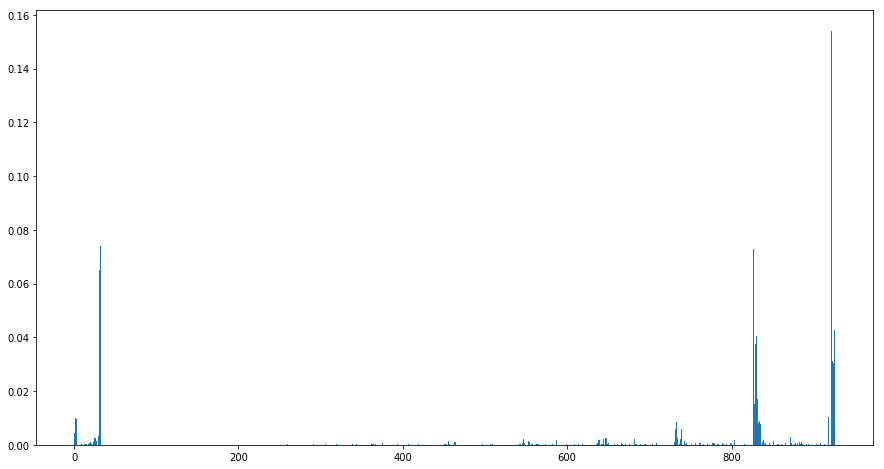

1 ActionOutcome0_# 0.154
2 ActionOutcome0_= 0.120
3 ActionAway0 0.074
4 ActionOutcome1_# 0.073
5 ActionHome0 0.065
6 ActionOutcome0_/ 0.043
7 ActionOutcome1_/ 0.040
8 ActionOutcome1_- 0.037
9 ActionOutcome0_+ 0.031
10 ActionOutcome0_- 0.030
11 ActionHome1 0.020
12 ActionType0_A 0.017
13 ActionOutcome1_+ 0.015
14 ActionOutcome0_! 0.014
15 ActionAway1 0.014
16 ActionEndZone0_Z= 0.011
17 ActionType1_A 0.010
18 ScoreMax 0.010
19 ScoreDiff 0.010
20 ActionType0_D 0.009
21 ActionOutcome2_- 0.008
22 ActionType0_B 0.008
23 ActionType0_E 0.008
24 ActionSpeed0 0.007
25 ActionOutcome1_! 0.007


In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
plt.bar(range(1,927),clf.feature_importances_)
plt.show()

indxs = clf.feature_importances_.argsort()[-25:][::-1]
for i in range(1,len(indxs)+1):
    idx = indxs[i-1]
    print('%d %s %.3f' % (i, X.columns[idx], clf.feature_importances_[idx]))

In [14]:
import pickle
y_prob = clf.predict_proba(Xn)
pickle.dump(y_prob, open('../output/y_probabilities_forest.pkl', 'wb'))

In [47]:
from sklearn import metrics
q_values_raw = pickle.load(open('../output/q_values_new.pkl', 'rb'))
q_values = np.asarray([q_values_raw[i,0] for i in range(len(q_values_raw))])
# clipping
q_values = q_values + 0.05
q_values[q_values>0.9] = 1
q_values[q_values<-0.9] = -1
nn_pred = np.sign(q_values)

forest_pred = clf.predict(Xn)
y_prob_forest = clf.predict_proba(Xn)
q_forest = y_prob_forest[:,1]*2 - 1

print("Accuracy Forest:", metrics.accuracy_score(forest_pred, vb.RewardValue))
print("Accuracy NN:", metrics.accuracy_score(nn_pred, vb.RewardValue))
print("Accuracy difference:", metrics.accuracy_score(nn_pred, vb.RewardValue)-metrics.accuracy_score(forest_pred, vb.RewardValue))

Accuracy Forest: 0.7782540225950018
Accuracy NN: 0.753974666210202
Accuracy difference: -0.024279356384799722


In [48]:
cond = (forest_pred == vb.RewardValue) & (nn_pred != vb.RewardValue)
print(sum(cond))
print(np.mean(forest_pred[cond]))
print(np.mean(nn_pred[cond]))
cond = (forest_pred != vb.RewardValue) & (nn_pred == vb.RewardValue)
print(sum(cond))
print(np.mean(forest_pred[cond]))
print(np.mean(nn_pred[cond]))
print(sum(nn_pred[cond]))
print()
for action in ['S','R','A','B','D','E','F']:
    for outcome in ['=','/','-','!','+','#']:
        cond = (forest_pred == vb.RewardValue) & (nn_pred != vb.RewardValue) & (vb.ActionType0 == action) & (vb.ActionOutcome0 == outcome)
        if sum(cond)>100:
            print(action, outcome, sum(cond), np.mean(q_values[cond]), np.mean(q_forest[cond]))

4694
-0.17213463996591394
0.17213464
1148
-0.18466898954703834
0.18466899
212.0

R ! 141 -0.008213272 -0.019275867968554815
A - 1383 0.05091197 -0.027756611128499323
A ! 604 0.072569035 -0.0673593709522946
A + 356 0.047530822 0.03703640236854779
B ! 195 -0.013098458 0.052957691723919384
B + 208 0.022104446 -0.033573195349919996
D ! 153 0.020672569 -0.03330463314591725
D # 549 0.03426113 -0.04553087148942353
E - 156 0.029210854 0.017590666174945497
E + 114 -0.0059759915 0.003586102816757345
E # 662 0.034388095 0.036519248830131815
